<a href="https://colab.research.google.com/github/royal-dit/tensorflow-deeplearning/blob/main/bitcoin%20price%20prediction/Bitcoin_price_prediciton_part_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as plt
 from sklearn.preprocessing import MinMaxScaler
 from tensorflow.keras.layers import Dense,Dropout,LSTM
 from tensorflow.keras.models import Sequential
 import requests
 import Xtensorflow as tf


In [ ]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


--2022-11-06 13:24:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-11-06 13:24:23 (8.89 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [ ]:
df=pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',parse_dates=['Date'],index_col=['Date'])
df.head(2)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383


In [ ]:
#only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)':"Price"})
bitcoin_prices.head()


,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:5],prices[:5]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866]))

#Model 9: Future Prediction Model

In [ ]:
HORIZON = 1
WINDOW_SIZE =7

In [ ]:
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head(4)


,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN


In [ ]:
#train model on entire model for next day 
X_all= bitcoin_prices_nbeats.dropna().drop("Price",axis=1).to_numpy()
#get labels
y_all=bitcoin_prices_nbeats.dropna()["Price"]

len(X_all),len(y_all)


(2780, 2780)

In [ ]:
#turn data into efficient tensor
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)


In [ ]:
#combine featiures and labels 
dataset_all = tf.data.Dataset.zip((features_dataset_all,labels_dataset_all))
#batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all= dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_all


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)
model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(128,activation = "relu"),
    tf.keras.layers.Dense(1)
])
model_9.compile(loss = tf.keras.losses.mae,
                optimizer = "adam"
                )
model_9.fit(dataset_all,
            
            epochs = 100)

In [ ]:
INTO_FUTURE = 14
def make_future_forecasts(values,model,into_future,window_size = WINDOW_SIZE) -> list:
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  for _ in range(INTO_FUTURE):
     #predict on the last window then append it again
     future_pred = model.predict(tf.expand_dims(last_window,axis=0))
     print(f"prediciting on :\n {last_window} -> prediciton: {tf.squeeze(future_pred).numpy()}\n")
     
     #append prediciton to future forecast
     future_forecast.append(tf.squeeze(future_pred).numpy())

     #update last window with new pred and get window_size 
     last_window = np.append(last_window,future_pred)[-WINDOW_SIZE:]
  
  return future_forecast







In [ ]:
future_forecast = make_future_forecasts(values = y_all,
                                        model = model_9,
                                        into_future = INTO_FUTURE,
                                        window_size = WINDOW_SIZE
                                        )

In [ ]:
def get_future_dates (start_date,into_future,offset = 1):
  start_date = start_date + np.timedelta64(offset,"D") #specify start date d
  end_date = start_date + np.timedelta64(into_future,"D") # specify end date
  return np.arange(start_date,end_date,dtype = "datetime64[D]") #retrun a date range betrween start and end date



In [ ]:
#last timestep of timesteps
last_timesteps = bitcoin_prices.index[-1]
last_timesteps

Timestamp('2021-05-18 00:00:00')

In [ ]:
#get next two week of timesteps 
next_time_steps = get_future_dates(start_date = last_timesteps,
                                   into_future = INTO_FUTURE
                                   )
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
import csv
from datetime import datetime
timesteps=[]
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv','r') as f:
  csv_reader = csv.reader(f,delimiter=",")
  next(csv_reader) #skip first line (get rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1],"%Y-%m-%d")) # get the dates as date not string
    btc_price.append(float(line[2])) # get the closing price as float


In [ ]:
#creating a plot function
def plot_time_series(timesteps,values,format='.',start=0,end=None,label=None):
  """
  timesteps: array pf timestpes values
  values: array of values across time
  format: style of plot,defalult
  start: where to start the plot
  end: where to end the plot
  label : label to show on plot about values , defalut is none

  """
  plt.plot(timesteps[start:end],values[start:end],format,label=label)
  plt.xlabel("Time")
  plt.ylabel('Btc price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

In [ ]:
#insert last time setp /final price into next time setp and future forecast
next_time_steps = np.insert(next_time_steps,0,last_timesteps)
future_forecast = np.insert(future_forecast,0,btc_price[-1])
next_time_steps,future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55881.53 , 51063.066, 48624.887, 48238.293, 48016.418,
        47004.75 , 48464.332, 54163.51 , 49864.21 , 47810.637, 48372.215,
        49084.75 , 48913.086, 50547.562], dtype=float32))

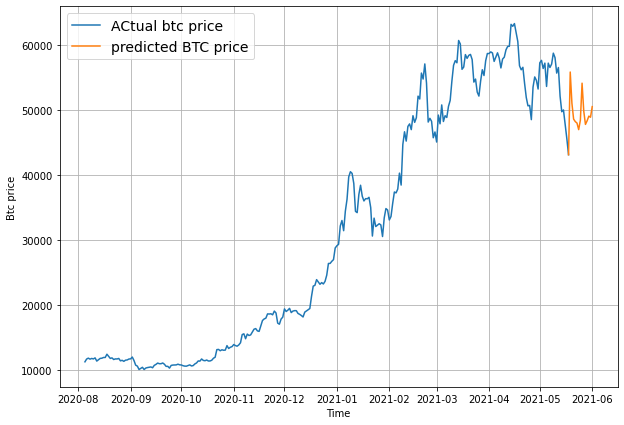

In [ ]:
#plot future price prediction of bitcoin
plt.figure(figsize = (10,7))
plot_time_series(bitcoin_prices.index , btc_price,start =2500,format = "-",label="ACtual btc price")
plot_time_series(next_time_steps,future_forecast,format="-",label = "predicted BTC price")
